# Import, Set working directory

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

pd.set_option("display.precision", 8)
sns.set_style(style = "darkgrid")

In [2]:
import os
def main():
    print("Current Working Directory " , os.getcwd())
    if os.path.exists("C:/Users/micha.DESKTOP-8HA2IGV/OneDrive/Programming/Propulsion Project/intelligencia_backup/intelligencia") :
        # Change the current working Directory    
        os.chdir("C:/Users/micha.DESKTOP-8HA2IGV/OneDrive/Programming/Propulsion Project/intelligencia_backup/intelligencia")
        print("New Working Directory " , os.getcwd())
    else:
        print("Can't change the Current Working Directory")    
        print("Current Working Directory " , os.getcwd())
if __name__ == '__main__':
    main()

Current Working Directory  C:\Users\micha.DESKTOP-8HA2IGV\OneDrive\Programming\Propulsion Project\intelligencia_backup\intelligencia\Mike
New Working Directory  C:\Users\micha.DESKTOP-8HA2IGV\OneDrive\Programming\Propulsion Project\intelligencia_backup\intelligencia


# Class: Data Preparation
Prepares data for feature selection algorithm
- Read Data
- Standard Deviation Filter
- Split Function
- Smote Upsampling


In [289]:
class DataPrep:
    def __init__(self, seed):
        self.seed = seed
    
  # Read Data
    def read_data(self, path, nrows, usecols):
        data = pd.read_csv(path, nrows=nrows, usecols=usecols)
        data.index = data.iloc[:,0]
        data.drop(columns = "Unnamed: 0", inplace = True)
        data.columns = [(re.sub('\.\d+', '', gene)) for gene in data.columns]
        return data
  
  # Filter with Standard Deviation Threshold
    def X_and_y(self, data, threshold):
        #data.describe()
        X = data.drop(columns = 'label')
        X_sd = X.loc[:, X.std() >= threshold]
        y = data[["label"]]
        return X_sd, y
  
  # Train Test Split data
    def split(self, X, y, test_size):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=self.seed)
        return X_train, X_test, y_train, y_test
  
  # Upsample unbalanced data
    def smote_up(self, X_train, y_train):
        #print("Before OverSampling, counts of label '1': {}".format(sum(y_train['label']==1)))
        #print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train['label']==0)))

        sm = SMOTE(random_state=self.seed)
        X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

        #print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
        #print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

        #print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote==1)))
        #print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote==0)))
        column_names = X_train.columns

        # Make dataframe again
        X_train_smote = pd.DataFrame(X_train_smote, columns=column_names)
        y_train_smote = pd.DataFrame(y_train_smote, columns=['label'])

        return X_train_smote, y_train_smote
    
    def bulbasaur(self, path, threshold = 2, nrows = None, usecols = None):
        data = self.read_data(path, nrows, usecols)
        X, y = self.X_and_y(data, threshold)
        X_train, X_test, y_train, y_test = self.split(X, y, 0.05)
        X_train_smote, y_train_smote = self.smote_up(X_train, y_train.values.ravel())
        return X_train_smote, y_train_smote, X_test, y_test
    
dataprep = DataPrep(1888)

# Class: ModelEvaluation (me)
Evaluate results of feature selection process and further select for the best genes (by visualizing the distributions).
The resulting selection will be fed into a multi-label XGBoost classifier.
- Retrieve top 50 genes (based on 1. Importance Score, 2. Total Count, 3. Overlaps with Cosmic Genes)
- Top All: Combines top genes from all cancer types
- Model Scores: Amount of overlaps with cosmic genes per feature selector
- Importance Scatter: Scatterplot of feature importance
- Cancer Specific df
- Visualize features
- Update feature selection

In [319]:
class ModelEvaluation:
    def __init__(self, seed):
        """
        Initialize seed
        """
        self.seed = seed

    def top_50(self, results_list, chunk_names):
        """
        This function selects the top 50 genes
        The selection is based on:
        - Importance Score
        - Total Count
        - Overlaps with Cosmic
        """
        dictionary = {}
        
        for results, chunk_name in zip(results_list, chunk_names):
            top = []
            top_30_count = results.sort_values(by="Total Count", ascending = False).head(30).index.tolist()
            top_30_score = results.sort_values(by="Importance Score", ascending = False).head(30).index.tolist() 

            results = results[results["Total Count"] > 1]
            top_30_cosmic = results[results["Cosmic"] == 1].index.tolist()[:30]


            for lst in [top_30_count, top_30_score, top_30_cosmic]:
                for element in lst:
                    top.append(element)

            seen = set()
            top_unique = [x for x in top if x not in seen and not seen.add(x)]
            
            dictionary[chunk_name] = top_unique
            print(chunk_name, ": ", str(len(top_unique)), "genes selected |", str(len(top)-len(top_unique)), "duplicates removed")

        return dictionary
    
    def top_all(self, dictionary):
        top_all = []
        for chunk in chunks:
            for element in dictionary[chunk]:
                top_all.append(element)

        seen = set()
        top_all_unique = [x for x in top_all if x not in seen and not seen.add(x)]
        print("Top genes overall: ", str(len(top_all_unique)), "genes selected |", str(len(top_all)-len(top_all_unique)), "duplicates removed")
        
        return pd.DataFrame({"top_genes":top_all_unique})

    def model_scores(self, results):
        """
        The Score is the count of genes selected that are present in the Intogen Gene List.
        """
        model_scores = results[results["Cosmic"] == 1].sum()
        model_scores = pd.DataFrame(model_scores).iloc[:5]
        model_scores.columns = ["Overlaps with Cosmic"]
        
        return model_scores
        
    def importances_scatter(self, results, column, ngenes = 20):
        """
        Scatterplot for importances
        """
        data = results[[column]].sort_values(by = column, ascending = False).head(ngenes)

        fig, ax = plt.subplots(figsize = (17,10))
        sns.scatterplot(data.index, data.iloc[:,0], ax=ax)
        plt.xticks(rotation=45)
        
    def cancer_specific_df(self, results, results_all):
        """
        Returns a Dataframe with gene selection specific to the cancer.
        It removed all genes selected by results_all
        """
        all_ = results_all.append(results).sort_values(by = "Total Count", ascending = False)
        overlap = all_[all_.index.duplicated()].index.tolist()
        results_filtered = results[~results.index.isin(overlap)]

        return results_filtered
    
    def visualize_selected_features(self, X, y, selected_features, chunk):
        """
        Visualize distributions
        """
        X_selected = X[selected_features]

        import seaborn as sns
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for count, i in enumerate(X_selected.columns):
            plt.subplot(14, 10, j+1)
            j += 1
            sns.distplot(X_selected[i][y["label"]==0], color='g', label = '0')
            sns.distplot(X_selected[i][y["label"]==1], color='r', label = '1')
            plt.legend(loc='best')
            plt.title(count)
        fig.suptitle('Analysis of selected genes for: ' + chunk)
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.show()
        
    def update_selection(self, dictionary, rem_list):
        """
        Removes genes that are visually not very promising
        """
        dictionary_updated = dictionary.copy()
        for chunk, rem in zip(chunks, rem_list):
            genes_remove = [dictionary_updated[chunk][index] for index in rem]
            dictionary_updated[chunk] = [x for x in dictionary_updated[chunk] if x not in genes_remove]
            print(chunk, ":   \t", str(len(dictionary_updated[chunk])), "genes selected |", str(len(rem)), "genes removed")

        return dictionary_updated
    
me = ModelEvaluation(1888)

# Load results

In [122]:
results_breast = pd.read_csv("Output/Results/Result_2.0_Breast.csv", index_col=0)
results_lung_a = pd.read_csv("Output/Results/Result_2.0_LungAdenocarcinoma_Lung.csv", index_col=0)
results_skin = pd.read_csv("Output/Results/Result_2.0_Skin.csv", index_col=0)
results_lung_s = pd.read_csv("Output/Results/Result_2.0_LungSquamousCellCarcinoma_Lung.csv", index_col=0)
results_thyroid = pd.read_csv("Output/Results/Result_2.0_Thyroid_ThyroidGland.csv", index_col=0)
results_all = pd.read_csv("Output/Results/Result_2.0_AllCancers_0vs1.csv", index_col=0)
results_colon = pd.read_csv("Output/Results/Result_2.0_Colon.csv", index_col=0)

results_list = [results_skin, results_thyroid, results_colon, results_breast, results_lung_a, results_lung_s, results_all]

# Evaluate Models

## Plot Feature Importances

In [110]:
imps = ['Importances: Gradient Boost Classifier',
       'Importances: Recursive Feature Elimination',
       'Importances: Elastic Net', 'Importances: Boruta Tree',
       'Importances: Lasso CV', 'Importance Score']

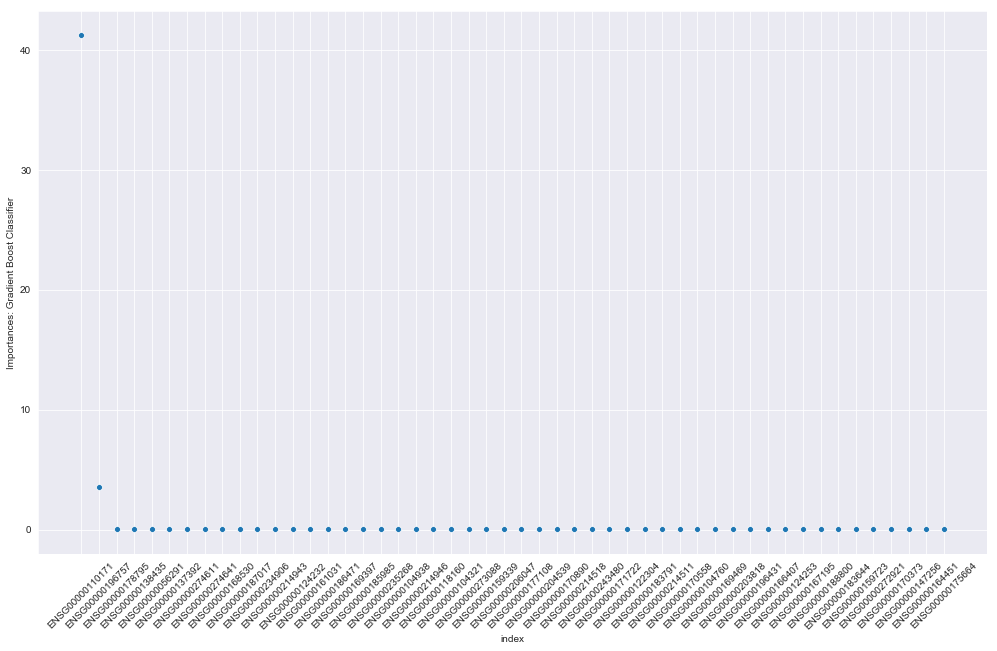

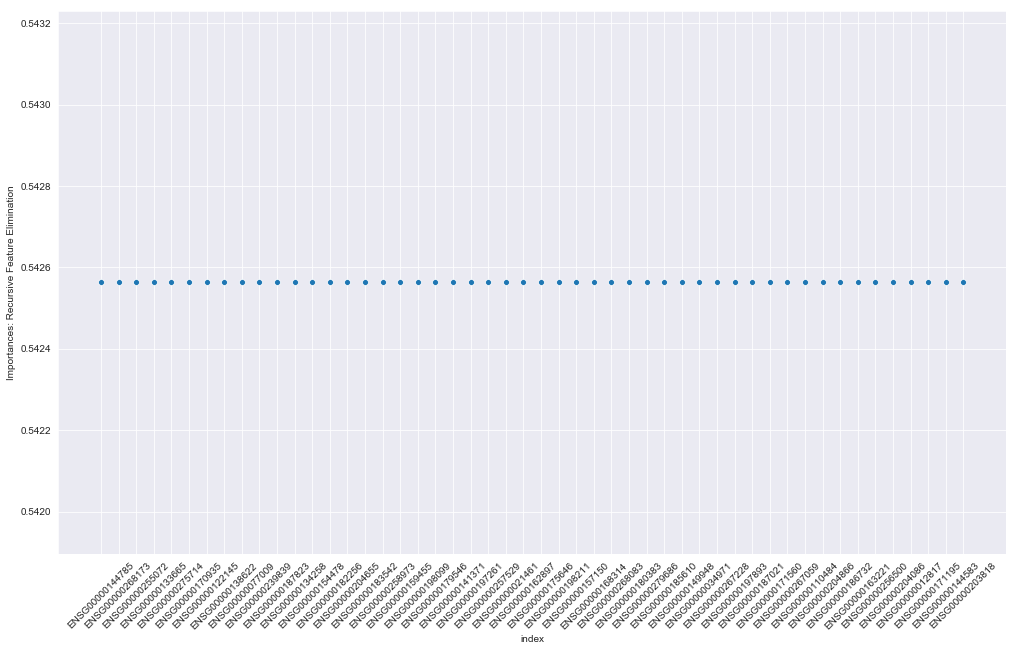

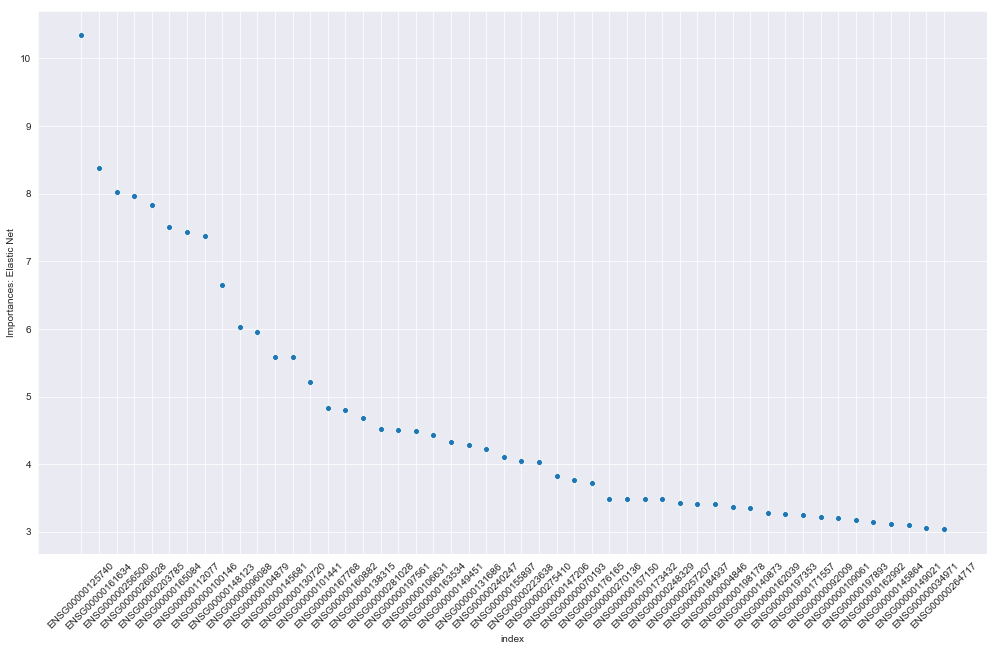

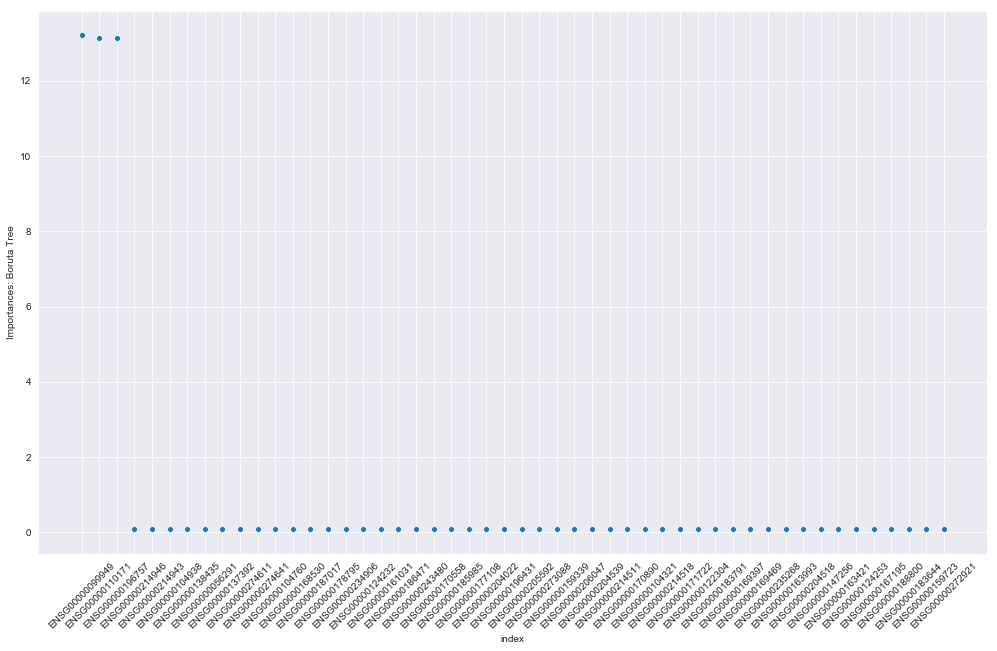

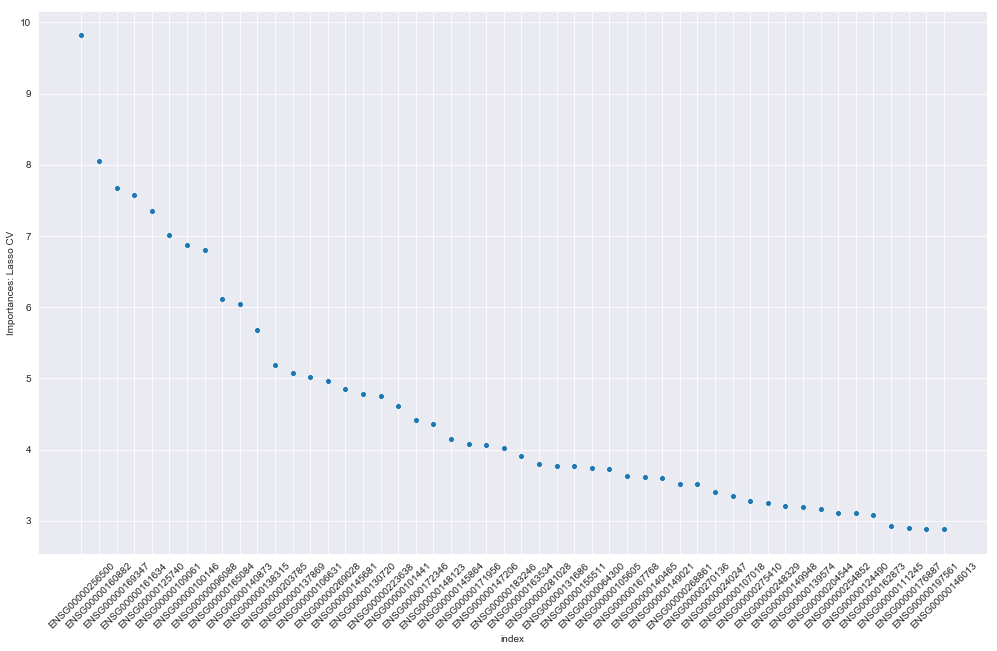

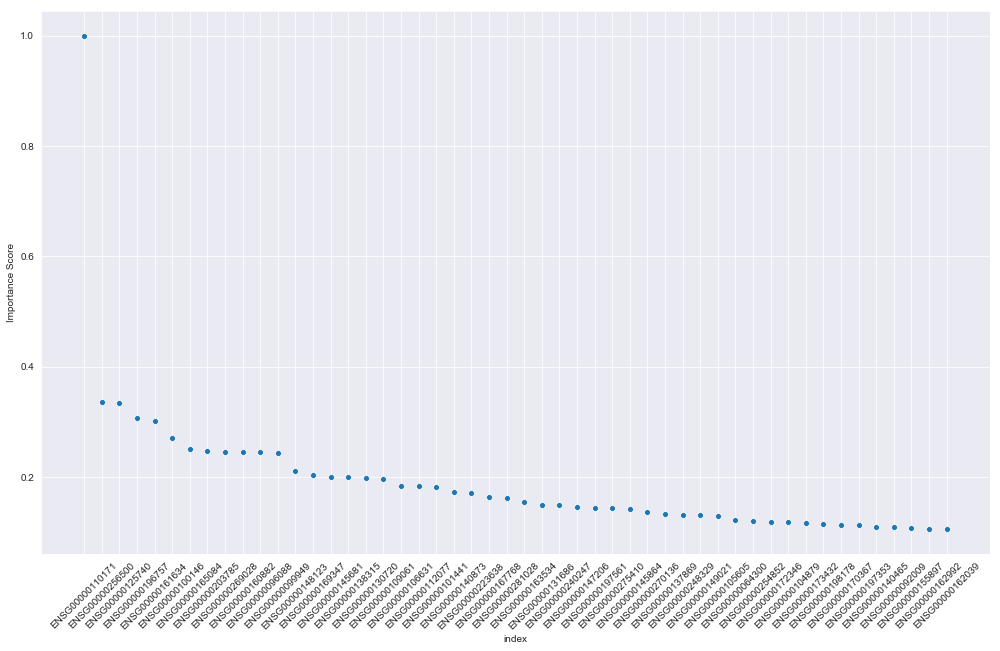

In [111]:
for x in imps:
    me.importances_scatter(results_thyroid, x, ngenes=50)

## Evaluate Amount of Overlaps with Cosmic

In [138]:
for results in results_list:
    model_df = me.model_scores(results)
    print(str(model) + "\n")
    print(model_df)
    print("-"*100 + "\n")

Gradient Boost Classifier

                              Overlaps with Cosmic
Gradient Boost Classifier                        6
Recursive Feature Elimination                    7
Elastic Net                                      6
Boruta Tree                                      9
Lasso CV                                         5
----------------------------------------------------------------------------------------------------

Gradient Boost Classifier

                              Overlaps with Cosmic
Gradient Boost Classifier                        7
Recursive Feature Elimination                    6
Elastic Net                                      4
Boruta Tree                                      7
Lasso CV                                         7
----------------------------------------------------------------------------------------------------

Gradient Boost Classifier

                              Overlaps with Cosmic
Gradient Boost Classifier                       11
R

## Visual Evaluation of Selected Genes

In [299]:
path_list = [
    "Output/Chunk_Skin.csv",
    "Output/Chunk_Thyroid_ThyroidGland.csv",
    "Output/Chunk_Colon.csv",
    "Output/Chunk_Breast.csv",
    "Output/Chunk_LungAdenocarcinoma_Lung.csv",
    "Output/Chunk_LungSquamousCellCarcinoma_Lung.csv",
    "Output/Chunk_AllCancers_0vs1.csv"]

# Keys for dictionary
chunks = ["skin", "thyroid", "colon", "breast", "lung_a", "lung_s", "all"]

# List of results dataframes
results_list = [results_skin, results_thyroid, results_colon, results_breast, results_lung_a, results_lung_s, results_all]

# Dictionary: Key - tissue, Value - list of selected genes
dictionary = me.top_50(results_list, chunks)

skin :  68 genes selected | 13 duplicates removed
thyroid :  80 genes selected | 4 duplicates removed
colon :  81 genes selected | 9 duplicates removed
breast :  74 genes selected | 7 duplicates removed
lung_a :  81 genes selected | 7 duplicates removed
lung_s :  84 genes selected | 6 duplicates removed
all :  82 genes selected | 8 duplicates removed


In [320]:
top_genes = me.top_all(dictionary)
top_genes.to_csv("Output/Results/Top_genes/top_genes_1.0.csv", index = False)

Top genes overall:  422 genes selected | 128 duplicates removed


In [321]:
df= pd.read_csv("Output/Results/Top_genes/top_genes_1.0.csv")

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422 entries, 0 to 421
Data columns (total 1 columns):
top_genes    422 non-null object
dtypes: object(1)
memory usage: 3.4+ KB


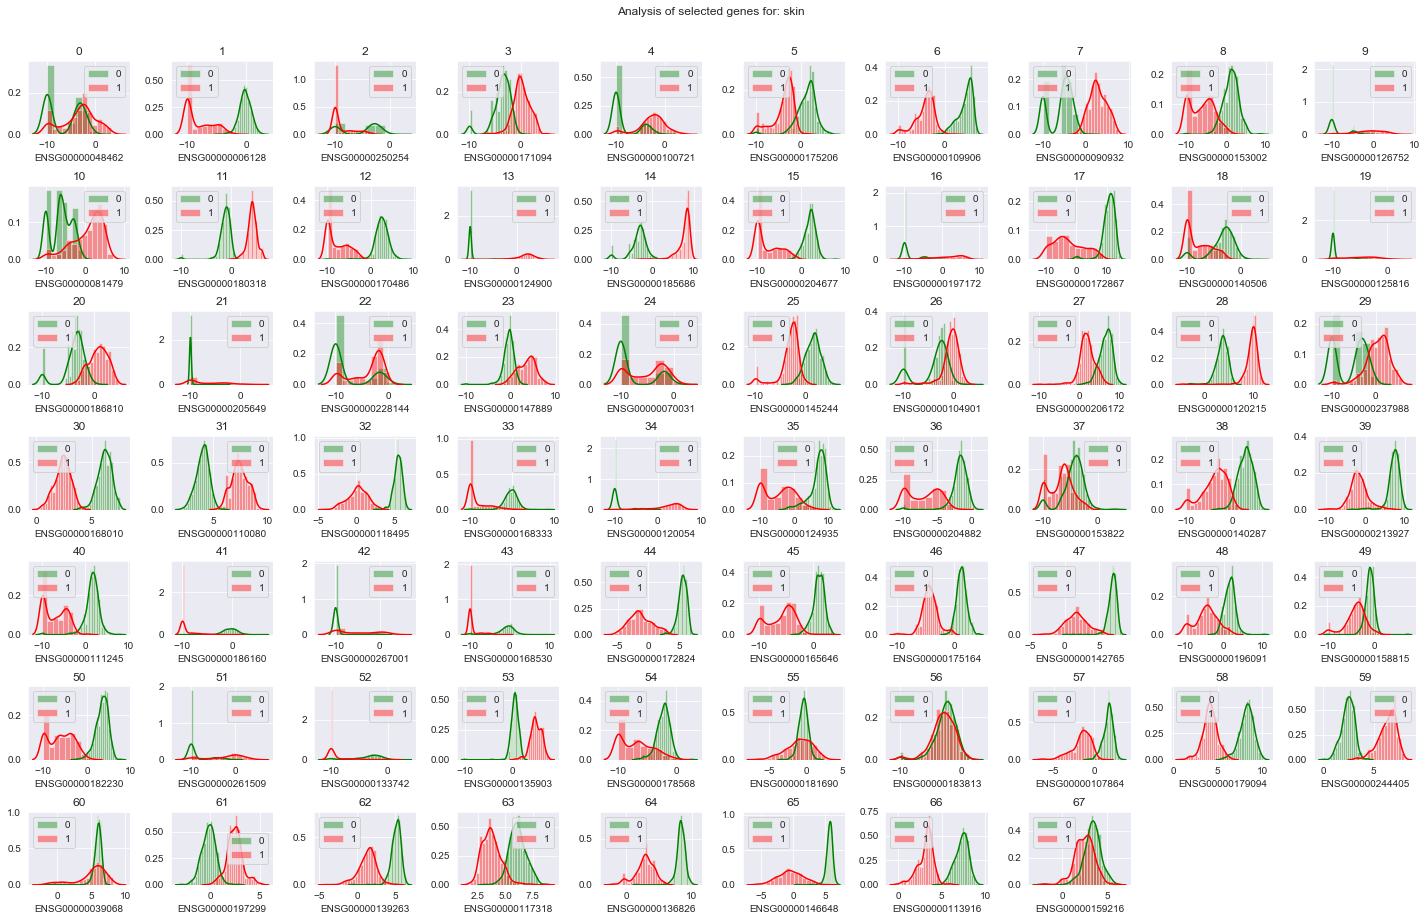

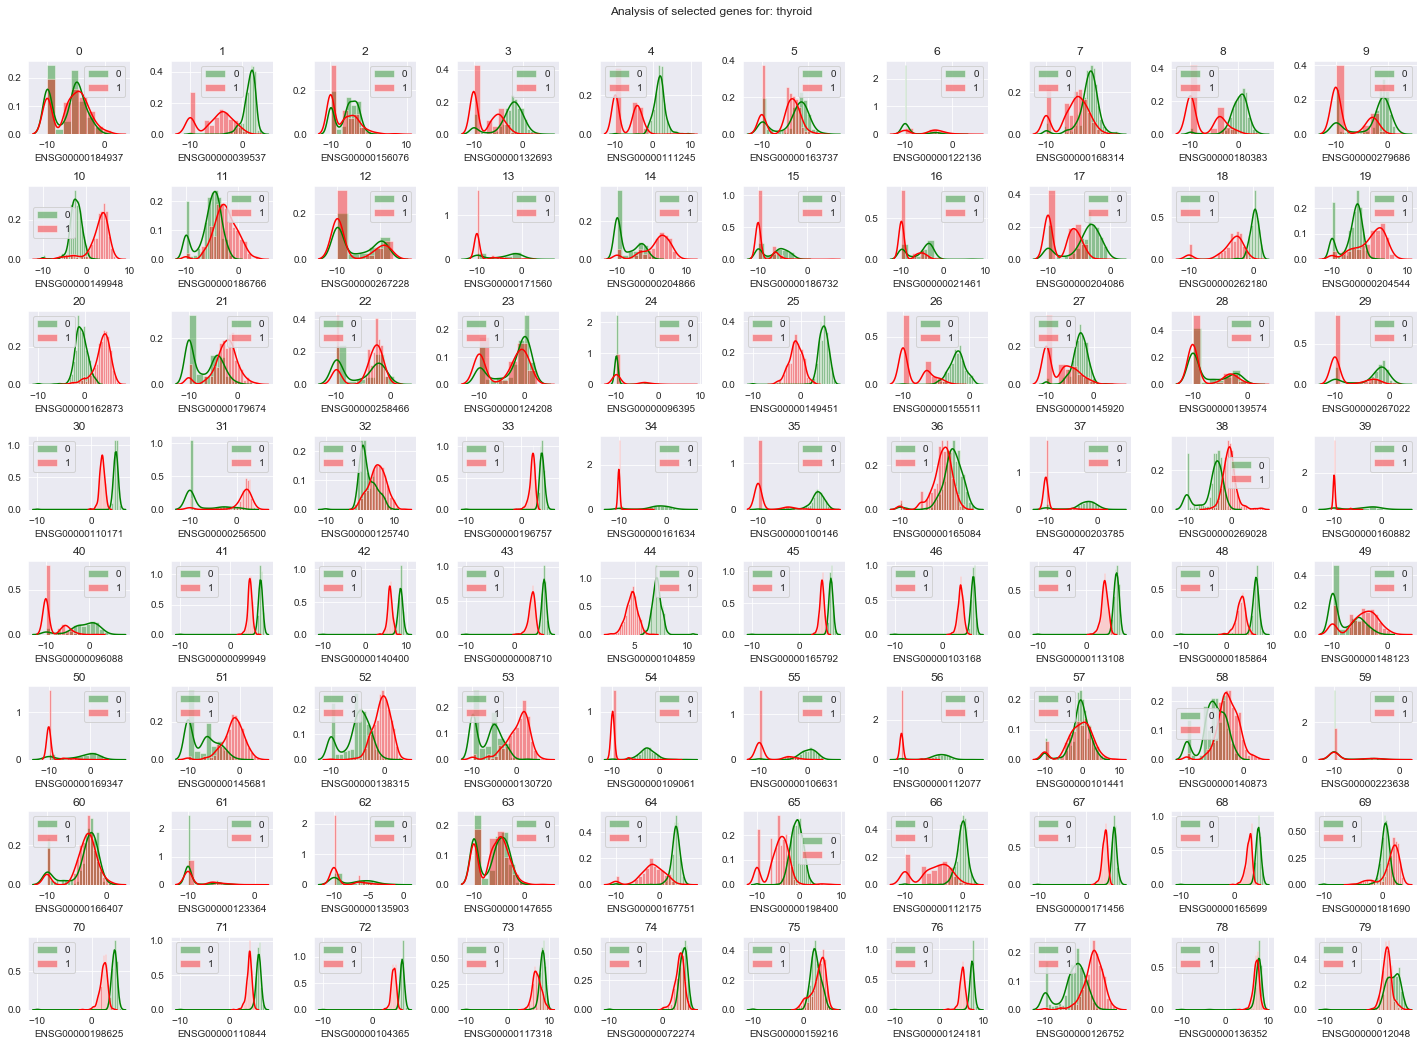

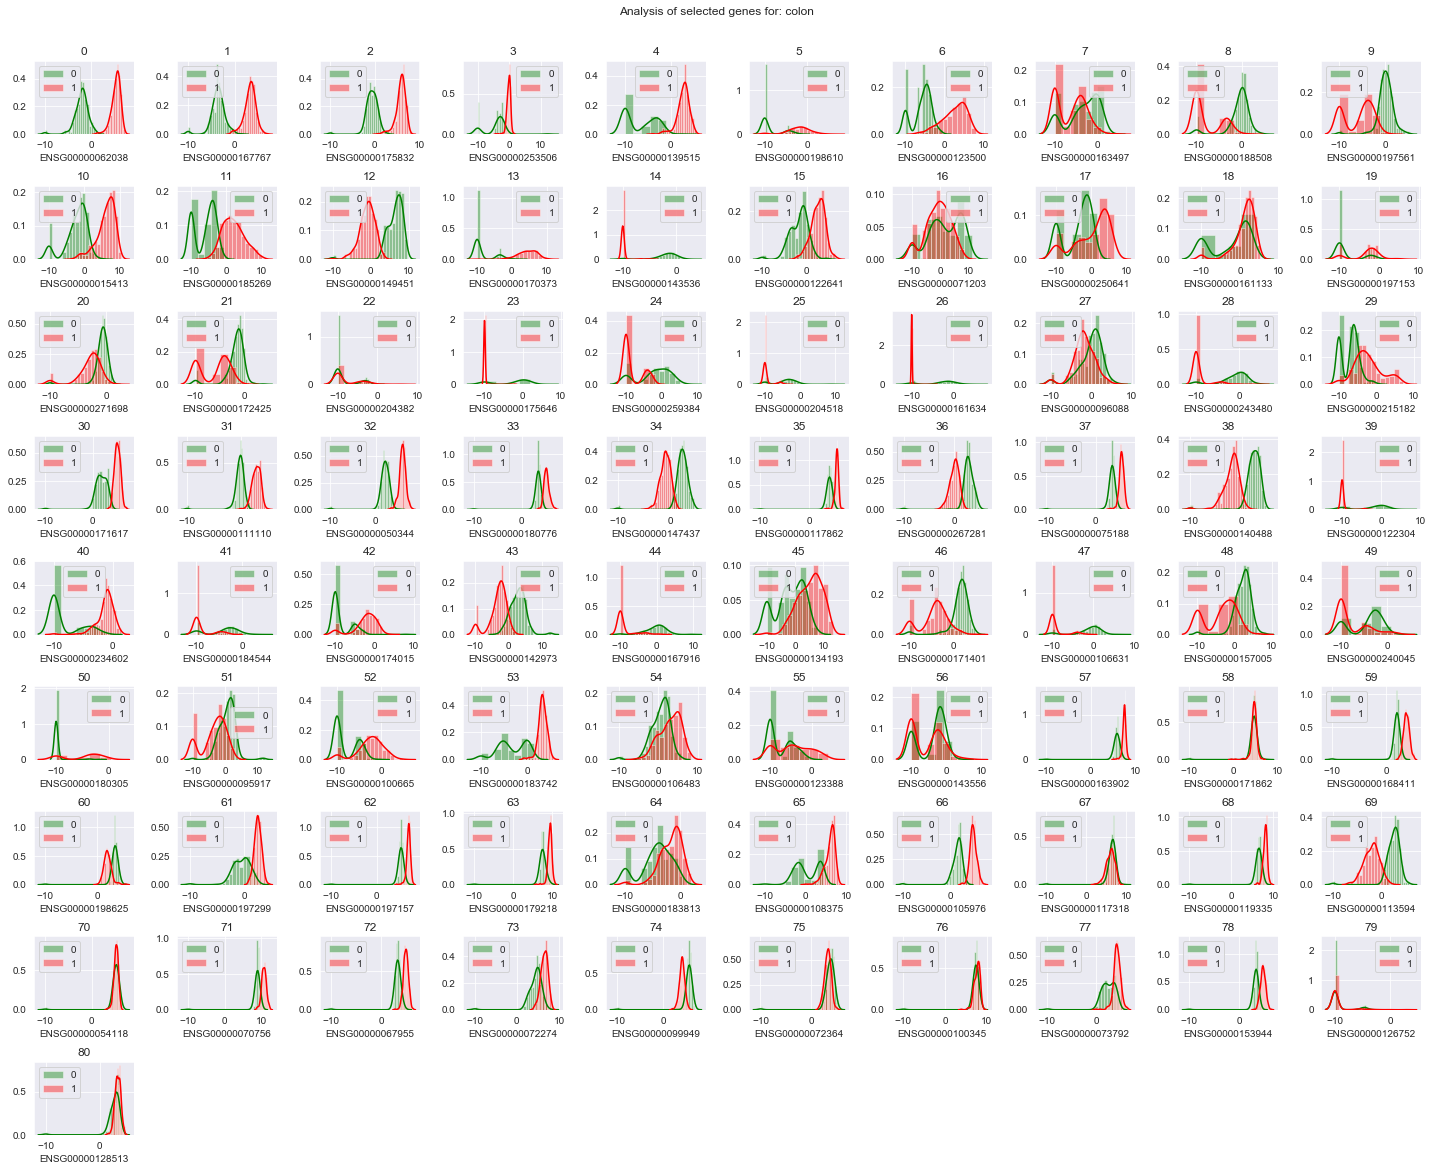

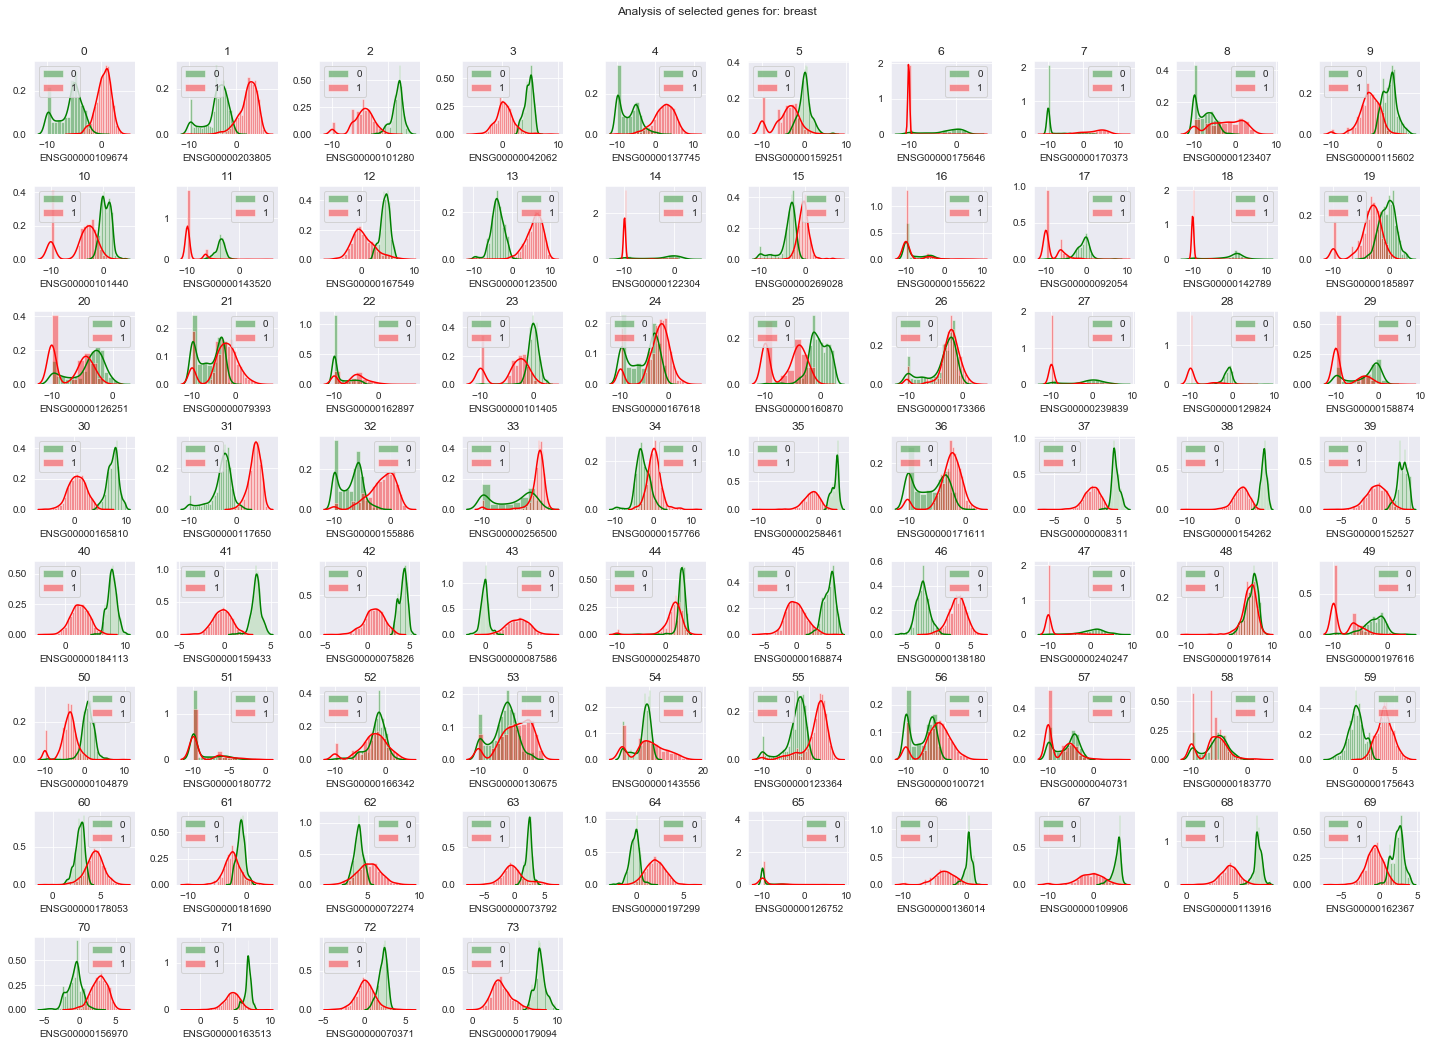

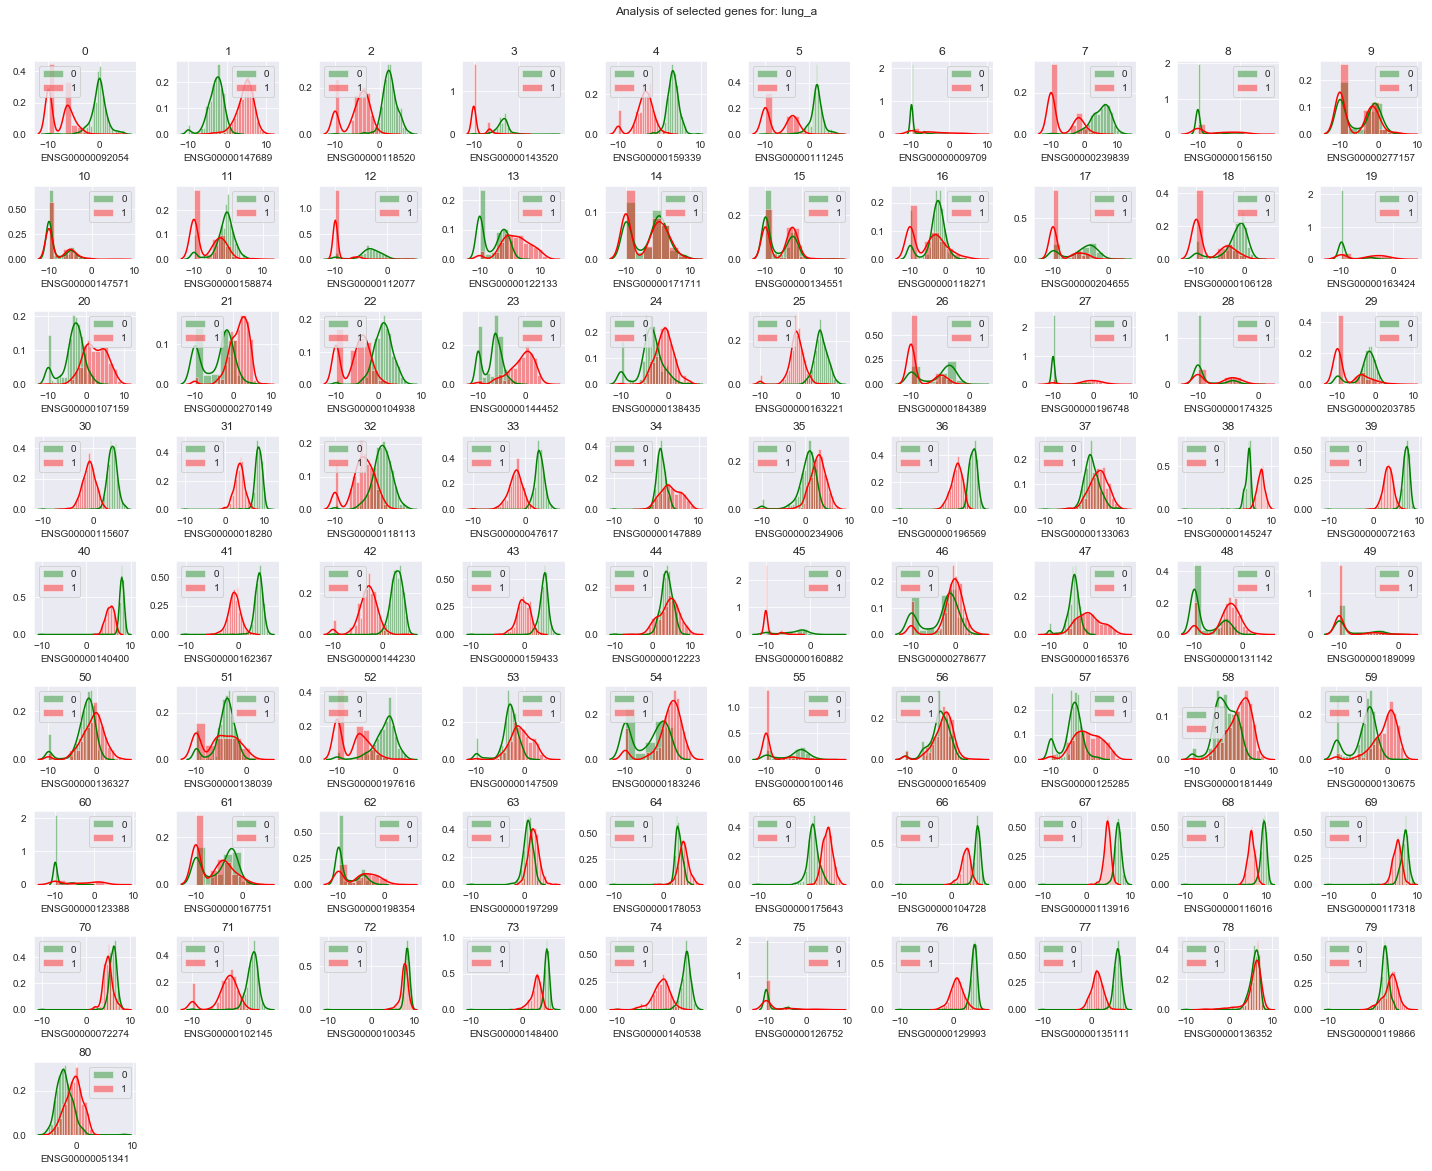

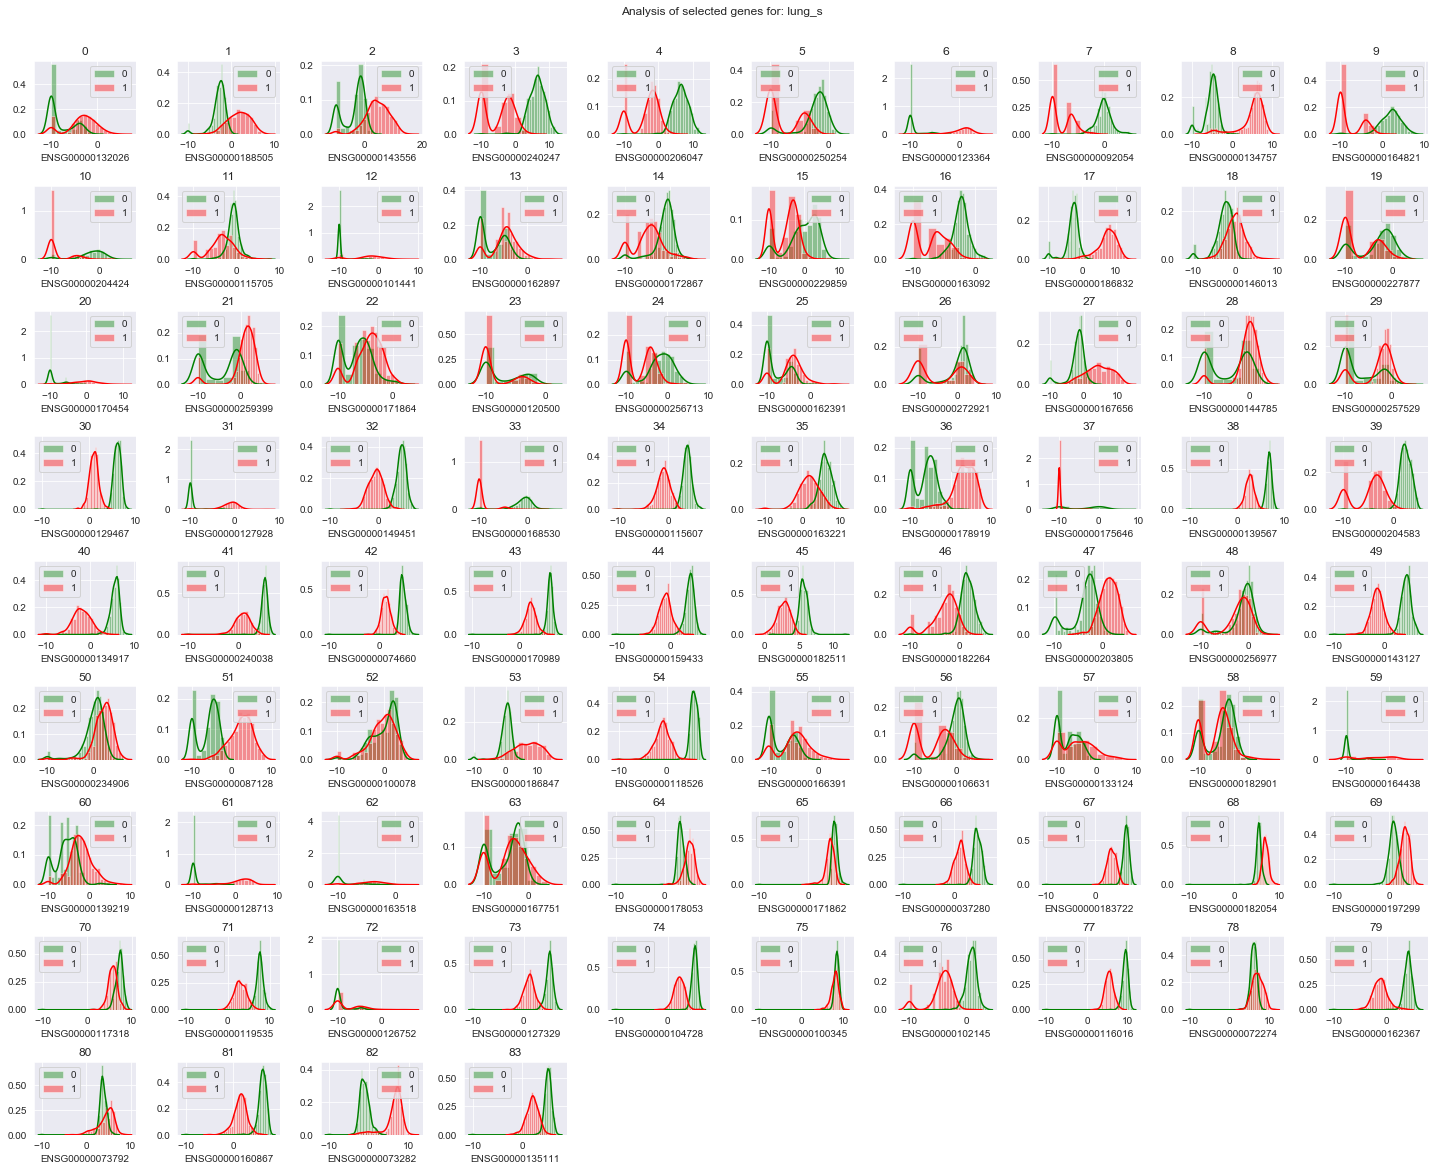

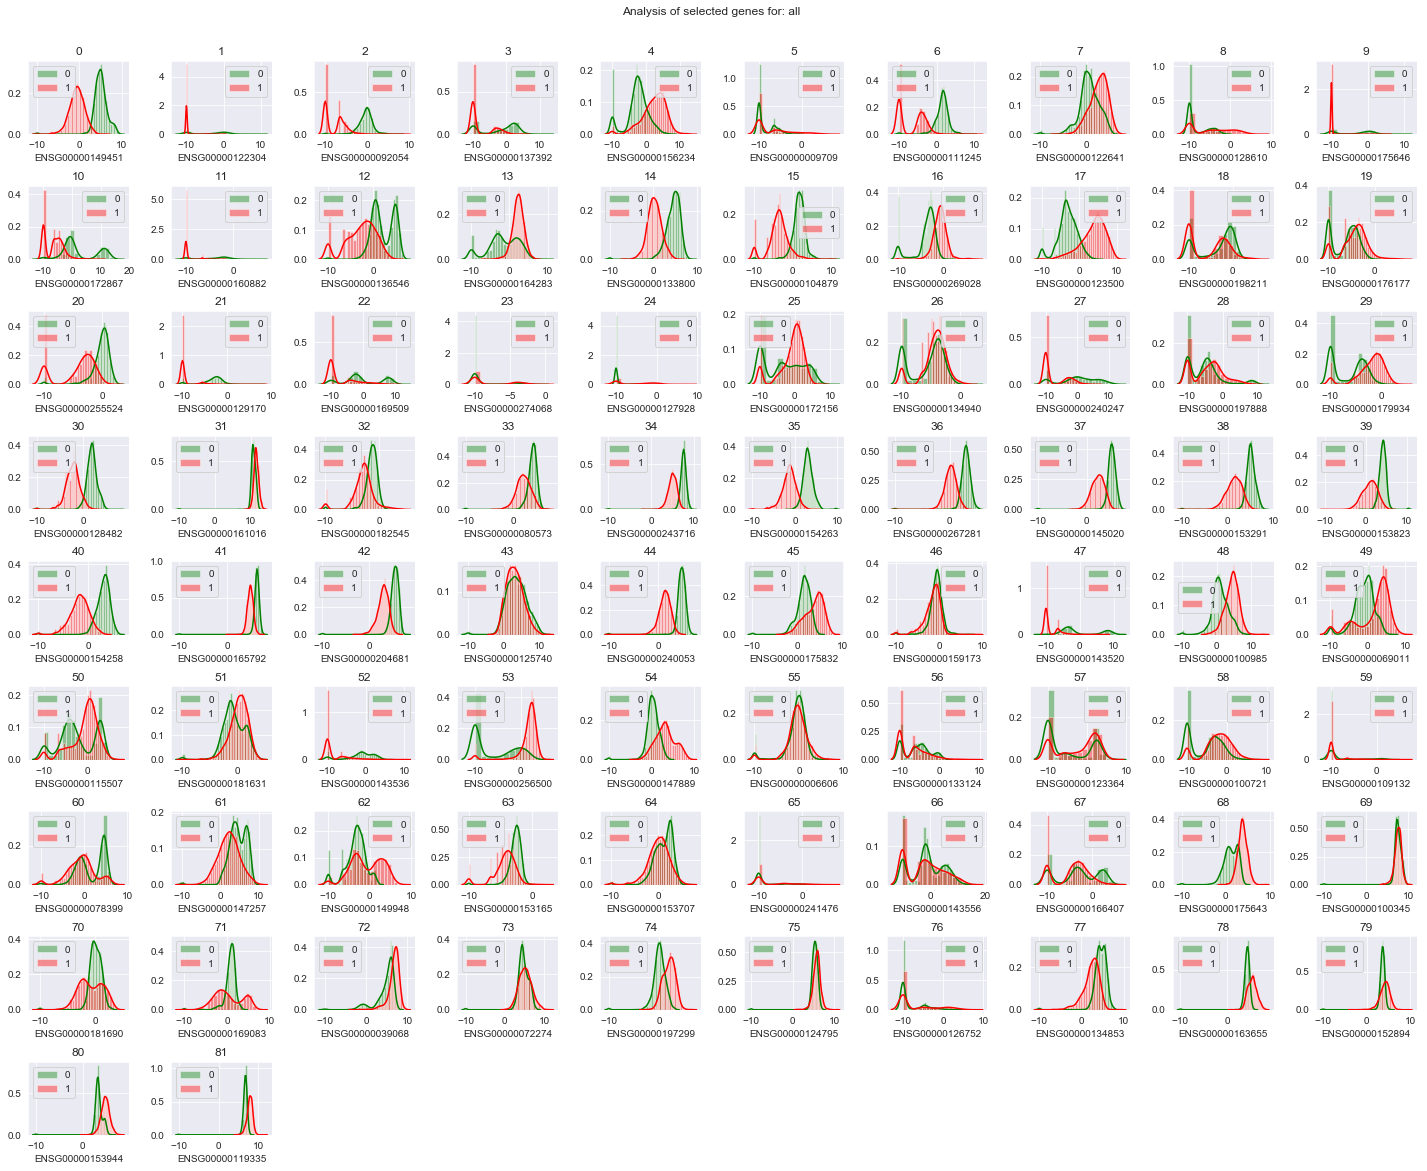

In [217]:
# Visualization of distributions - It will help to determine which of the genes we want to keep.
for path, chunk in zip(path_list, chunks):
    X_train, y_train, X_test, y_test = dataprep.bulbasaur(path, threshold = 0, nrows = None, usecols = None)
    me.visualize_selected_features(X_train, y_train, dictionary[chunk], chunk)

# Update Gene Selection

In [285]:
remove_skin = [1, 3, 2]
remove_thyroid = [1, 3, 2]
remove_colon = [1, 3, 2]
remove_breast = [1, 3, 2]
remove_lung_a = [1, 3, 2]
remove_lung_s = [1, 3, 2]
remove_all = [1, 3, 2]

rem_list = [remove_skin, remove_thyroid, remove_colon, remove_breast, remove_lung_a, remove_lung_s, remove_all]

In [287]:
update_selection(dictionary, rem_list);

skin :   	 65 genes selected | 3 genes removed
thyroid :   	 77 genes selected | 3 genes removed
colon :   	 78 genes selected | 3 genes removed
breast :   	 71 genes selected | 3 genes removed
lung_a :   	 78 genes selected | 3 genes removed
lung_s :   	 81 genes selected | 3 genes removed
all :   	 79 genes selected | 3 genes removed


In [ ]:
pd.DataFrame(dictionary)